In [27]:
from transformers import ViTModel, ViTImageProcessor
import torch.nn as nn
from PIL import Image
from pathlib import Path
import os
import torch

In [10]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
RAW_DATA_DIR = PROJECT_DIR / "data" / "raw"
IMAGES_DIR = RAW_DATA_DIR / "images"

In [11]:
# Load the pre-trained ViT model
model = ViTModel.from_pretrained('google/vit-base-patch16-224')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


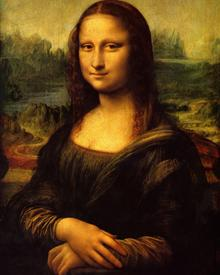

In [12]:
image = Image.open(IMAGES_DIR / "leonardo-da-vinci_mona-lisa.jpg")
image

In [21]:
inputs = processor(image, return_tensors="pt")

In [32]:
with torch.no_grad():
    outputs = model(**inputs).last_hidden_state
outputs[0][0].shape

torch.Size([768])

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class ViTForMultiClassification(nn.Module):
    def __init__(self, num_classes_multiclass_classifications, num_classes_multilabel_classifications):
        super(ViTForMultiClassification, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")

        self.multiclass_fcs = [
            nn.Linear(768, num_classes)
            for num_classes
            in num_classes_multiclass_classifications
        ]
        self.multilabel_fcs = [
            nn.Linear(768, num_classes)
            for num_classes
            in num_classes_multilabel_classifications
        ]

    def forward(self, pixel_values):
        x = self.vit(pixel_values).last_hidden_state
        cls = x[:, 0, :]

        multiclass_outputs = tuple(
            fc(cls)
            for fc in self.multiclass_fcs
        )
        multilabel_outputs = tuple(
            fc(cls)
            for fc in self.multilabel_fcs
        )

        return multiclass_outputs + multilabel_outputs

In [57]:
model = ViTForMultiClassification([2, 2], [3])

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
inputs["pixel_values"]

tensor([[[[-0.0667, -0.0196,  0.0667,  ...,  0.1294,  0.1529,  0.1529],
          [-0.0902, -0.0275,  0.0588,  ...,  0.1529,  0.1451,  0.1294],
          [-0.0902, -0.0039,  0.0824,  ...,  0.1608,  0.1373,  0.1216],
          ...,
          [-0.8431, -0.8431, -0.8431,  ..., -0.9059, -0.9137, -0.9137],
          [-0.8431, -0.8431, -0.8431,  ..., -0.9137, -0.9137, -0.9137],
          [-0.8431, -0.8431, -0.8431,  ..., -0.9137, -0.9137, -0.9137]],

         [[-0.0588, -0.0196,  0.0353,  ..., -0.0275, -0.0118, -0.0118],
          [-0.0824, -0.0275,  0.0275,  ..., -0.0118, -0.0196, -0.0353],
          [-0.0824, -0.0118,  0.0510,  ..., -0.0118, -0.0275, -0.0431],
          ...,
          [-0.9294, -0.9294, -0.9294,  ..., -0.9686, -0.9608, -0.9608],
          [-0.9294, -0.9294, -0.9294,  ..., -0.9608, -0.9608, -0.9608],
          [-0.9294, -0.9294, -0.9294,  ..., -0.9608, -0.9608, -0.9608]],

         [[-0.6078, -0.5765, -0.5216,  ..., -0.7098, -0.7098, -0.7098],
          [-0.6235, -0.5765, -

In [58]:
with torch.no_grad():
    outputs = model(inputs["pixel_values"])

In [59]:
outputs

(tensor([[-0.4556, -0.7136]]),
 tensor([[ 0.2342, -1.1681]]),
 tensor([[0.3639, 0.1015, 1.0962]]))

In [53]:
def multiclassification_loss(multiclass_outputs, multiclass_targets, multilabel_outputs, multilabel_targets):
    multiclass_losses = [
        F.cross_entropy(output, target)
        for output, target 
        in zip(multiclass_outputs, multiclass_targets)
    ]
    multilabel_losses = [
        F.binary_cross_entropy_with_logits(output, target)
        for output, target
        in zip(multilabel_outputs, multilabel_targets)
    ]
    return sum(multiclass_losses + multilabel_losses)